# 任务二：VAE 变分自编码器 (MindSpore 版)
继续用 CIFAR-10，但为了加速，只抽样约 100 张图训练，20 张做重构展示。


## 环境与导包


In [13]:
import os, random, pickle
import numpy as np
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import nn, ops, Tensor
import mindspore.dataset as ds
from mindspore import context 

from PIL import Image

ms.set_context(mode=context.PYNATIVE_MODE, device_target="Ascend", device_id=0)
ms.set_seed(7)
np.random.seed(7)
random.seed(7)
print("Device:", ms.get_context("device_target"))


Device: Ascend


## 读入 CIFAR-10 并子采样
训练用 100 张，测试用 20 张，随机但固定种子以便复现。


In [14]:
data_root = "./dataset/cifar-10-batches-py"

def load_batch(file_path):
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
    data = data_dict['data'] if 'data' in data_dict else data_dict[b'data']
    labels_raw = data_dict.get('labels') if 'labels' in data_dict else data_dict.get(b'labels')
    images = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(labels_raw, dtype=np.int32)
    return images, labels

def load_cifar10(root):
    train_imgs, train_labels = [], []
    for i in range(1, 6):
        imgs, labs = load_batch(os.path.join(root, f"data_batch_{i}"))
        train_imgs.append(imgs)
        train_labels.append(labs)
    train_images = np.concatenate(train_imgs)
    train_labels = np.concatenate(train_labels)
    test_images, test_labels = load_batch(os.path.join(root, "test_batch"))
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_cifar10(data_root)

subset_train = 2000
subset_test = 400
rng = np.random.RandomState(7)
train_idx = rng.choice(train_images.shape[0], subset_train, replace=False)
test_idx = rng.choice(test_images.shape[0], subset_test, replace=False)
train_images = train_images[train_idx]
test_images = test_images[test_idx]

print("Subsampled Train:", train_images.shape)
print("Subsampled Test :", test_images.shape)





Subsampled Train: (2000, 32, 32, 3)
Subsampled Test : (400, 32, 32, 3)


## 数据预处理与 DataLoader
仅做归一化到 [0,1]，转 CHW。数据量小，batch 也可稍小。


In [15]:
def to_tensor(img):
    arr = img.astype(np.float32) / 255.0
    return arr.transpose(2, 0, 1)

class VAEDataset:
    def __init__(self, images):
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return to_tensor(self.images[idx])

batch_size = 32
train_ds = ds.GeneratorDataset(VAEDataset(train_images), ["image"], shuffle=True)
train_ds = train_ds.batch(batch_size, drop_remainder=True)





## 模型结构：编码器/重参数化/解码器


In [16]:
class Encoder(nn.Cell):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.net = nn.SequentialCell([
            nn.Conv2d(3, 64, 4, stride=2, padding=1, pad_mode="pad"), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, pad_mode="pad"), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, pad_mode="pad"), nn.BatchNorm2d(256), nn.ReLU(),
        ])
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Dense(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Dense(256 * 4 * 4, latent_dim)
    def construct(self, x):
        x = self.net(x)
        x = self.flatten(x)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Cell):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Dense(latent_dim, 256 * 4 * 4)
        self.net = nn.SequentialCell([
            nn.Conv2dTranspose(256, 128, 4, stride=2, padding=1, pad_mode="pad"), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2dTranspose(128, 64, 4, stride=2, padding=1, pad_mode="pad"), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2dTranspose(64, 3, 4, stride=2, padding=1, pad_mode="pad"), nn.Sigmoid()
        ])
    def construct(self, z):
        x = self.fc(z)
        x = ops.reshape(x, (z.shape[0], 256, 4, 4))
        return self.net(x)

class VAE(nn.Cell):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    def reparameterize(self, mu, logvar):
        eps = ops.StandardNormal()(mu.shape)
        std = ops.exp(0.5 * logvar)
        return mu + std * eps
    def construct(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar


## 损失函数：重构 + KL


In [17]:
def vae_loss(recon, x, mu, logvar, beta=1.0, eps=1e-7):
    # Binary cross-entropy recon loss
    recon = ops.clip_by_value(recon, eps, 1.0 - eps)
    bce = - (x * ops.log(recon) + (1 - x) * ops.log(1 - recon))
    recon_loss = ops.mean(bce)
    kl = -0.5 * ops.mean(1 + logvar - ops.square(mu) - ops.exp(logvar))
    return recon_loss + beta * kl, recon_loss, kl

class VAEWithLoss(nn.Cell):
    def __init__(self, net, beta=1.0):
        super().__init__()
        self.net = net
        self.beta = beta
    def construct(self, x):
        recon, mu, logvar = self.net(x)
        total, recon_l, kl_l = vae_loss(recon, x, mu, logvar, beta=self.beta)
        return total, recon_l, kl_l


## 训练循环
数据量很小，默认 1 轮示意。记录总损失/重构/ KL。


In [ ]:
latent_dim = 128
num_epochs = 20
learning_rate = 1e-3
min_beta = 0.05
max_beta = 1.0
warmup_ratio = 0.3  # first 30% steps to ramp beta

net = VAE(latent_dim=latent_dim)
optimizer = nn.Adam(net.trainable_params(), learning_rate=learning_rate)
params = optimizer.parameters

steps_per_epoch = max(1, train_images.shape[0] // batch_size)
total_steps = num_epochs * steps_per_epoch

loss_history, recon_history, kl_history, beta_history = [], [], [], []
for epoch in range(num_epochs):
    net.set_train()
    for step, batch in enumerate(train_ds.create_dict_iterator()):
        x = batch["image"]
        global_step = epoch * steps_per_epoch + step
        progress = global_step / max(1, total_steps - 1)
        ramp = min(1.0, progress / warmup_ratio) if warmup_ratio > 0 else 1.0
        beta = min_beta + (max_beta - min_beta) * ramp

        def forward_fn(data):
            recon, mu, logvar = net(data)
            total, recon_l, kl_l = vae_loss(recon, data, mu, logvar, beta=beta)
            return total, (recon_l, kl_l)

        (loss, (recon_l, kl_l)), grads = ops.value_and_grad(forward_fn, None, params, has_aux=True)(x)
        optimizer(grads)

        loss_history.append(float(loss.asnumpy()))
        recon_history.append(float(recon_l.asnumpy()))
        kl_history.append(float(kl_l.asnumpy()))
        beta_history.append(beta)
        if step % 20 == 0:
            print(f"Epoch {epoch+1} Step {step}: loss={loss_history[-1]:.4f}, recon={recon_history[-1]:.4f}, kl={kl_history[-1]:.4f}, beta={beta:.3f}")


Epoch 1 Step 0: loss=0.7795, recon=0.7731, kl=0.1268, beta=0.050
Epoch 1 Step 20: loss=0.6629, recon=0.6458, kl=0.1688, beta=0.101
Epoch 1 Step 40: loss=0.6555, recon=0.6402, kl=0.1002, beta=0.152
Epoch 1 Step 60: loss=0.6590, recon=0.6369, kl=0.1089, beta=0.203
Epoch 2 Step 0: loss=0.6581, recon=0.6396, kl=0.0887, beta=0.208
Epoch 2 Step 20: loss=0.6566, recon=0.6324, kl=0.0933, beta=0.260
Epoch 2 Step 40: loss=0.6586, recon=0.6387, kl=0.0641, beta=0.311
Epoch 2 Step 60: loss=0.6666, recon=0.6481, kl=0.0509, beta=0.362
Epoch 3 Step 0: loss=0.6619, recon=0.6380, kl=0.0652, beta=0.367
Epoch 3 Step 20: loss=0.6638, recon=0.6417, kl=0.0527, beta=0.418
Epoch 3 Step 40: loss=0.6663, recon=0.6466, kl=0.0419, beta=0.469
Epoch 3 Step 60: loss=0.6633, recon=0.6433, kl=0.0385, beta=0.520
Epoch 4 Step 0: loss=0.6636, recon=0.6404, kl=0.0441, beta=0.525
Epoch 4 Step 20: loss=0.6690, recon=0.6488, kl=0.0351, beta=0.576
Epoch 4 Step 40: loss=0.6675, recon=0.6519, kl=0.0248, beta=0.628
Epoch 4 Step 6

## Loss 可视化


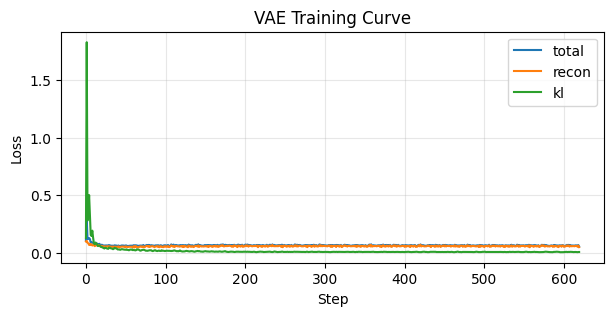

In [41]:
if loss_history:
    print(f"Recorded {len(loss_history)} steps")
    # total
    plt.figure(figsize=(6,3))
    plt.plot(loss_history)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('VAE Total Loss')
    plt.grid(alpha=0.3)
    plt.show()
    # recon
    plt.figure(figsize=(6,3))
    plt.plot(recon_history, color='tab:orange')
    plt.xlabel('Step')
    plt.ylabel('Recon Loss (BCE)')
    plt.title('VAE Recon Loss')
    plt.grid(alpha=0.3)
    plt.show()
    # kl
    plt.figure(figsize=(6,3))
    plt.plot(kl_history, color='tab:green')
    plt.xlabel('Step')
    plt.ylabel('KL Loss')
    plt.title('VAE KL Loss')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('Run training first.')


## 重构效果对比
用抽样测试集的 20 张图做输入/输出对比。


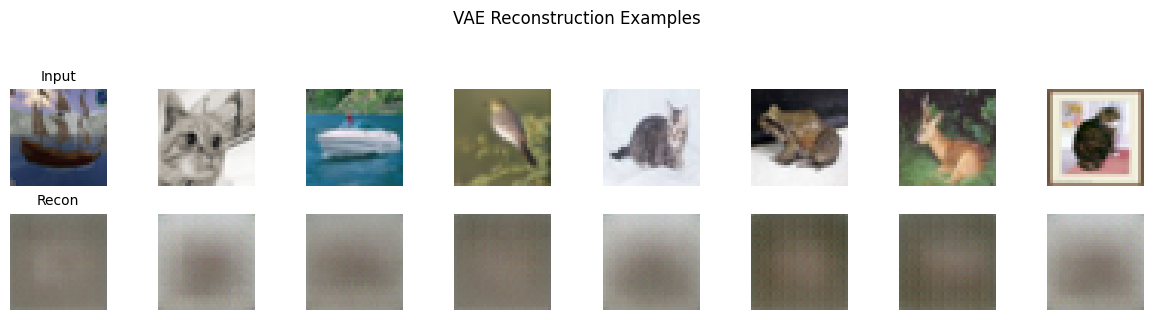

In [42]:
net.set_train(False)
sample = test_images[:8]
x = Tensor(np.stack([to_tensor(img) for img in sample]), ms.float32)
recon, _, _ = net(x)
recon_np = recon.asnumpy()

def denorm(t):
    t = np.clip(t, 0, 1)
    t = (t * 255).astype(np.uint8)
    return t.transpose(0,2,3,1)

fig, axes = plt.subplots(2, 8, figsize=(12,3))
for i in range(8):
    axes[0, i].imshow(sample[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(denorm(recon_np)[i])
    axes[1, i].axis('off')
axes[0,0].set_title('Input', fontsize=10)
axes[1,0].set_title('Recon', fontsize=10)
plt.suptitle('VAE Reconstruction Examples', y=1.05)
plt.tight_layout()
plt.show()



## 随机采样生成（选做）
从标准正态采样 latent，直接解码生成。


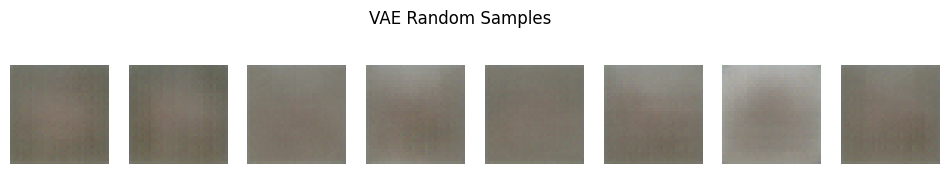

In [43]:
net.set_train(False)
num_samples = 8
z = ops.StandardNormal()((num_samples, latent_dim))
fake = net.decoder(z)
fake_np = fake.asnumpy()
fig, axes = plt.subplots(1, num_samples, figsize=(12,2))
for i in range(num_samples):
    img = np.clip(fake_np[i], 0, 1)
    axes[i].imshow((img.transpose(1,2,0) * 255).astype(np.uint8))
    axes[i].axis('off')
plt.suptitle('VAE Random Samples', y=1.02)
plt.show()

